In [1]:
import os
os.chdir('..')

In [2]:
from model.network import Converter
import matplotlib.pyplot as plt

Using TensorFlow backend.


In [3]:
plt.rcParams["figure.figsize"] = (20,20)

In [4]:
import os
import pickle
from pathlib import Path

import numpy as np
import tensorflow as tf
import lpips_tf

from keras import backend as K
from keras import optimizers, losses, regularizers
from keras.layers import Conv2D, Dense, UpSampling2D, LeakyReLU, Activation
from keras.layers import Layer, Input, Reshape, Lambda, Flatten, Concatenate, Embedding, GaussianNoise
from keras.models import Model, load_model
from keras.callbacks import ReduceLROnPlateau, EarlyStopping, Callback
from keras.applications import vgg16
from keras_lr_multiplier import LRMultiplier
from assets import AssetManager

In [5]:
class LORDClassShuffeler:
    def __init__(self, digit, subset=None,
                 base_dir = 'results', model_name = 'minst_10_model', data_name = 'minst_10_test'):
        self.digit = digit
        assets = AssetManager(base_dir)
        data = np.load(assets.get_preprocess_file_path(data_name))
        imgs, classes, contents, n_classes = data['imgs'], data['classes'], data['contents'], data['n_classes']
        imgs = imgs.astype(np.float32) / 255.0
        curr_zero_idx = (classes == digit)
        if subset is not None:
            curr_zero_idx[subset:] = False # if have the time use np.csum isntead
        self.curr_imgs = imgs[curr_zero_idx,]
        self.n_images = self.curr_imgs.shape[0]
        
        self.converter = Converter.load( assets.get_model_dir(model_name), include_encoders=True)
        self.content_codes = self.converter.content_encoder.predict(self.curr_imgs)
        class_codes = self.converter.class_encoder.predict(self.curr_imgs)
        self.class_adain_params = self.converter.class_modulation.predict(class_codes)
        
    def generate_plot(self, n_images=10):
        blank = np.zeros_like(self.curr_imgs[0])
        output = [np.concatenate([blank] + list(self.curr_imgs[:n_images]), axis=1)]
        for i in range(n_images):
            generated_imgs = [
                self.converter.generator.predict([self.content_codes[[j]], self.class_adain_params[[i]]])[0]
                for j in range(n_images)
            ]

            converted_imgs = [self.curr_imgs[i]] + generated_imgs

            output.append(np.concatenate(converted_imgs, axis=1))

        merged_img = np.concatenate(output, axis=0)

        plt.imshow(np.squeeze(merged_img), cmap='gray') # TODO save to file
        plt.savefig(f'{self.digit}')
        
    def recontrruction_error(self, batch_size=32):        
        image_shape = (batch_size, 64, 64, 3)
        image0 = np.random.random(image_shape)
        image1 = np.random.random(image_shape)
        image0_ph = tf.placeholder(tf.float32)
        image1_ph = tf.placeholder(tf.float32)

        distance_t = lpips_tf.lpips(image0_ph, image1_ph, model='net-lin', net='alex')
        to_batch = lambda x: np.concatenate([np.tile(imgs, (1,1,1,3)) for imgs in x], axis=0)
        total_distance = None

        for i in range(self.n_images):
            generated_imgs = to_batch([
                self.converter.generator.predict([self.content_codes[[j]], self.class_adain_params[[i]]])[0]
                for j in range(self.n_images) if i != j
            ])
            same_content_imgs = to_batch([self.curr_imgs[j] for j in range(self.n_images) if i != j])
            with tf.Session() as session:
                distance = session.run(distance_t, feed_dict={image0_ph: generated_imgs[idx * batch_size:(idx + 1) * batch_size],
                                                                  image1_ph: same_content_imgs[idx * batch_size:(idx + 1) * batch_size]})
                total_distance = np.mean(distance)
#                 for idx in range(int(np.ceil((self.n_images-1) / batch_size))):
#                     distance = session.run(distance_t, feed_dict={image0_ph: generated_imgs[idx * batch_size:(idx + 1) * batch_size],
#                                                                   image1_ph: same_content_imgs[idx * batch_size:(idx + 1) * batch_size]})
#                     if total_distance is None:
#                         total_distance = np.mean(distance)
#                     else:
#                         total_distance = ((total_distance*idx * batch_size) + np.sum(distance)) / ((idx * batch_size) + len(distance))
        return total_distance

loading models...
vgg arch:
Model: "vgg"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_14 (InputLayer)        (None, 64, 64, 1)         0         
_________________________________________________________________
lambda_7 (Lambda)            (None, 64, 64, 3)         0         
_________________________________________________________________
vgg_normalization_7 (VggNorm (None, 64, 64, 3)         0         
_________________________________________________________________
model_7 (Model)              [(None, 64, 64, 64), (Non 14714688  
Total params: 14,714,688
Trainable params: 14,714,688
Non-trainable params: 0
_________________________________________________________________
loading models...
vgg arch:
Model: "vgg"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_16 (InputLayer)        (None, 64, 64, 1)  

KeyboardInterrupt: 

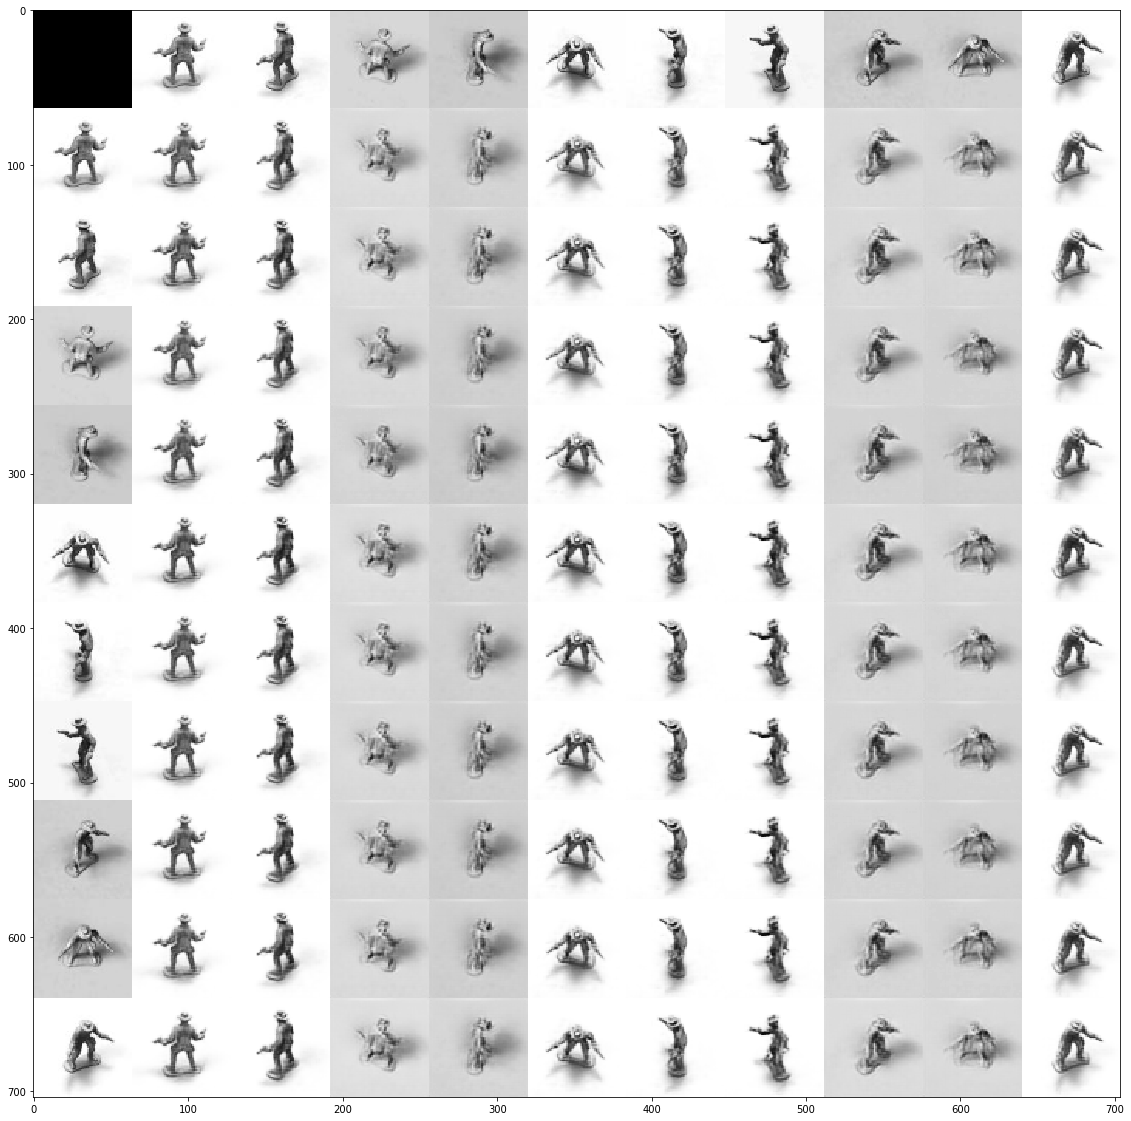

In [10]:
with open('class_shuffle_eval_res.txt', 'w+') as f:
    for digit in range(10):
        sh = LORDClassShuffeler(digit, 1000, model_name = 'smallnorb_model_strict_50_128', data_name = 'smallnorb_strict_class_test')
        sh.generate_plot(10)
#         err = sh.recontrruction_error(32)
#         print(f'{digit}\t{err}\n')
#         f.write(f'{digit}\t{err}\n')